<a href="https://colab.research.google.com/github/betelhem1234/delete/blob/main/skin%20cancer%20detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import cv2
import numpy as np
import seaborn as sns
from os import listdir
import tensorflow as tf
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam 
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from keras.callbacks import ModelCheckpoint,EarlyStopping,CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img,img_to_array
from tensorflow.keras.utils import img_to_array
# from keras_preprocessing.image import img_to_array
from keras.layers import Conv2D,MaxPooling2D,BatchNormalization,InputLayer,Flatten, Dropout, Dense,Activation

In [30]:
!pip install split-folders #for spliting dataset with a given ratio
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import splitfolders
IMAGE_SIZE = 256
BATCH_SIZE =8
EPOCHS = 20
CHANNELS=3
LR = 1e-4


In [4]:
disease_name=['basal cell carcinoma','melanoma','normal','pigmented benign keratosis','not skin']
disease_name

['basal cell carcinoma',
 'melanoma',
 'normal',
 'pigmented benign keratosis',
 'not skin']

In [ ]:
 # path_to_training_dataset = '../input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor

Image_Generator = Augmentor.Pipeline('/content/drive/MyDrive/project/cancer/basal cell carcinoma/', output_directory='/content/drive/MyDrive/Augmentor/basal cell carcinoma/')
Image_Generator.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
Image_Generator.flip_top_bottom(probability=0.8)
Image_Generator.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)
Image_Generator.shear(probability=0.5, max_shear_left=10, max_shear_right=10)
Image_Generator.flip_left_right(probability=0.5)
Image_Generator.random_distortion(probability=0.5, grid_width=4, grid_height=4, magnitude=8)

Image_Generator.sample(500)

Initialised with 392 image(s) found.
Output directory set to /content/drive/MyDrive/Augmentor/basal cell carcinoma/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F783C73A1F0>: 100%|██████████| 500/500 [00:43<00:00, 11.52 Samples/s]


In [6]:
splitfolders.ratio('/content/drive/MyDrive/Augmentors', output="/content/drive/MyDrive/project/out_put5", seed=1335, ratio=(0.8, 0.1,0.1)) 


Copying files: 0 files [00:00, ? files/s]
Copying files: 1 files [00:00,  4.08 files/s]
Copying files: 2 files [00:01,  1.56 files/s]
Copying files: 3 files [00:02,  1.35 files/s]
Copying files: 4 files [00:02,  1.23 files/s]
Copying files: 5 files [00:04,  1.09s/ files]
Copying files: 6 files [00:05,  1.00 files/s]
Copying files: 7 files [00:06,  1.03 files/s]
Copying files: 8 files [00:07,  1.05 files/s]
Copying files: 9 files [00:08,  1.05 files/s]
Copying files: 10 files [00:09,  1.07 files/s]
Copying files: 11 files [00:09,  1.11 files/s]
Copying files: 12 files [00:21,  4.16s/ files]
Copying files: 22 files [00:21,  1.27 files/s]
Copying files: 33 files [00:21,  2.84 files/s]
Copying files: 42 files [00:21,  4.61 files/s]
Copying files: 54 files [00:21,  7.85 files/s]
Copying files: 63 files [00:22, 10.99 files/s]
Copying files: 74 files [00:22, 16.00 files/s]
Copying files: 85 files [00:22, 22.00 files/s]
Copying files: 94 files [00:22, 27.87 files/s]
Copying files: 105 files [

In [7]:
Image_Generator = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=10,
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.3,
    fill_mode="reflect"
)

In [8]:
train='/content/drive/MyDrive/project/out_put5/train'
val='/content/drive/MyDrive/project/out_put5/val'
test='/content/drive/MyDrive/project/out_put5/test'

In [9]:
train_generator=Image_Generator.flow_from_directory(
    train,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    color_mode="rgb",
    shuffle=True,
    seed=123
)


Found 4000 images belonging to 5 classes.


In [10]:
val_datagen=ImageDataGenerator(
    rescale=1.0/255,
)
val_generator=val_datagen.flow_from_directory(
    val,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    class_mode="sparse",
    shuffle=True,
    seed=123
)


Found 500 images belonging to 5 classes.


In [11]:
test_datagen=ImageDataGenerator(
    rescale=1.0/255,
)
test_generator=test_datagen.flow_from_directory(
    test,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    color_mode="rgb",
    class_mode="sparse",
)

Found 500 images belonging to 5 classes.


In [12]:
#number of train,val and test dataset
train_generator.samples,val_generator.samples,test_generator.samples

(4000, 500, 500)

In [13]:
class_name_indices=train_generator.class_indices
class_names=list(class_name_indices.keys())
class_names

['basal cell carcinoma',
 'melanoma',
 'normal',
 'not skin',
 'pigmented benign keratosis']

In [14]:
num_classes = len(class_names)
num_classes

5

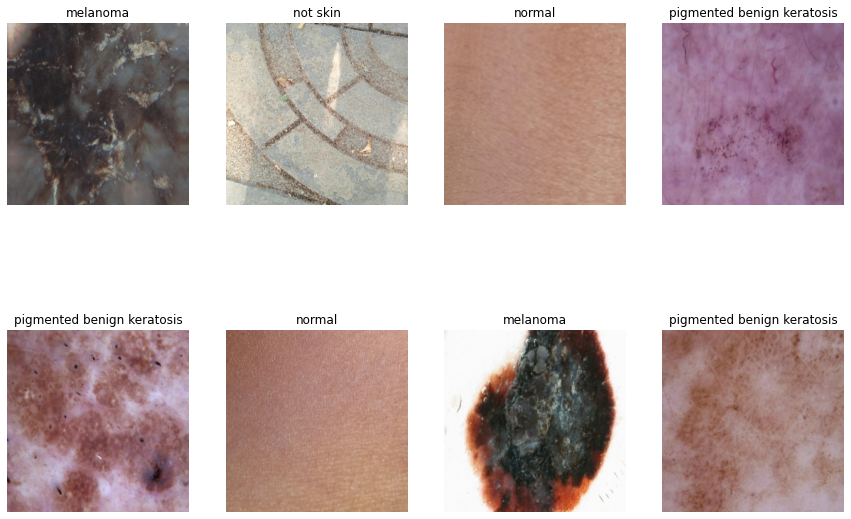

In [15]:
plt.figure(figsize=(15,16))
for image_batch,label_batch in train_generator:
    for i in range(8):
        plt.subplot(3,4,i+1)
        plt.imshow((image_batch[i]*255).astype(np.uint8)) 
        plt.title( class_names[int(label_batch[i])])
        plt.axis('off')
    break

In [16]:
input_shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
model =Sequential([
        InputLayer(input_shape=input_shape),


       Conv2D(32, (3,3),padding='same', activation='relu'),
         MaxPooling2D((2, 2)),

          Conv2D(64, (3,3),padding='same', activation='relu'),
         MaxPooling2D((2, 2)),

         Conv2D(128, (3,3),padding='same', activation='relu'),
         MaxPooling2D((2, 2)),

         Conv2D(256, (3,3), padding='same',activation='relu'),
         MaxPooling2D((2, 2)),

         Conv2D(512, (3, 3),padding='same',activation='relu'),
         MaxPooling2D((2, 2)),

         Conv2D(1024, (3, 3),padding='same',activation='relu'),
         MaxPooling2D((2, 2)),
         

         Conv2D(1024, (3, 3),padding='same',activation='relu'),
         MaxPooling2D((2, 2)),
         

         Flatten(),

         Dense(1024,activation='relu'),
         Dense(128,activation='relu'),

         Dense(64,activation='relu'),

         Dense(5,activation='softmax')
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 128)      0

In [20]:
model_check_point=ModelCheckpoint(filepath="/content/drive/MyDrive/project/best_model5.h5",
                   monitor="val_loss",
                   verbose=0,
                   save_best_only=True)
early_stop=EarlyStopping(monitor="val_accuracy",patience=30,verbose=1)
log_csv=CSVLogger('/content/drive/MyDrive/project/my_logs5.csv',separator=',',append=False)
call_backs=[model_check_point,early_stop,log_csv]
opt = Adam(learning_rate=LR)

In [21]:
model.compile(
optimizer=opt,
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy'])
print("[INFO] training network...")

[INFO] training network...


In [22]:
steps_per_epoch=int((train_generator.samples)/BATCH_SIZE)
validation_step=int((val_generator.samples)/BATCH_SIZE)
steps_per_epoch,validation_step

(500, 62)

In [23]:
history=model.fit(
     train_generator,
     verbose=1,
     epochs=20,
     callbacks=call_backs,
     batch_size=BATCH_SIZE,
     validation_data=val_generator,
     steps_per_epoch=steps_per_epoch,
     validation_steps=validation_step
        
)

Epoch 1/20
500/500 [==============================] - 389s 745ms/step - loss: 1.2450 - accuracy: 0.4083 - val_loss: 0.8509 - val_accuracy: 0.6109
Epoch 2/20
500/500 [==============================] - 365s 729ms/step - loss: 0.8759 - accuracy: 0.6150 - val_loss: 0.9790 - val_accuracy: 0.5806
Epoch 3/20
500/500 [==============================] - 360s 719ms/step - loss: 0.7085 - accuracy: 0.7175 - val_loss: 0.5357 - val_accuracy: 0.7621
Epoch 4/20
500/500 [==============================] - 374s 748ms/step - loss: 0.5512 - accuracy: 0.7857 - val_loss: 0.5320 - val_accuracy: 0.7823
Epoch 5/20
500/500 [==============================] - 360s 719ms/step - loss: 0.5076 - accuracy: 0.8075 - val_loss: 0.5934 - val_accuracy: 0.7802
Epoch 6/20
500/500 [==============================] - 370s 740ms/step - loss: 0.4339 - accuracy: 0.8303 - val_loss: 0.4001 - val_accuracy: 0.8347
Epoch 7/20
500/500 [==============================] - 360s 721ms/step - loss: 0.4241 - accuracy: 0.8378 - val_loss: 0.4161 -

In [24]:
model.evaluate(test_generator)

63/63 [==============================] - 52s 835ms/step - loss: 0.2677 - accuracy: 0.9200


[0.26766106486320496, 0.9200000166893005]

In [25]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

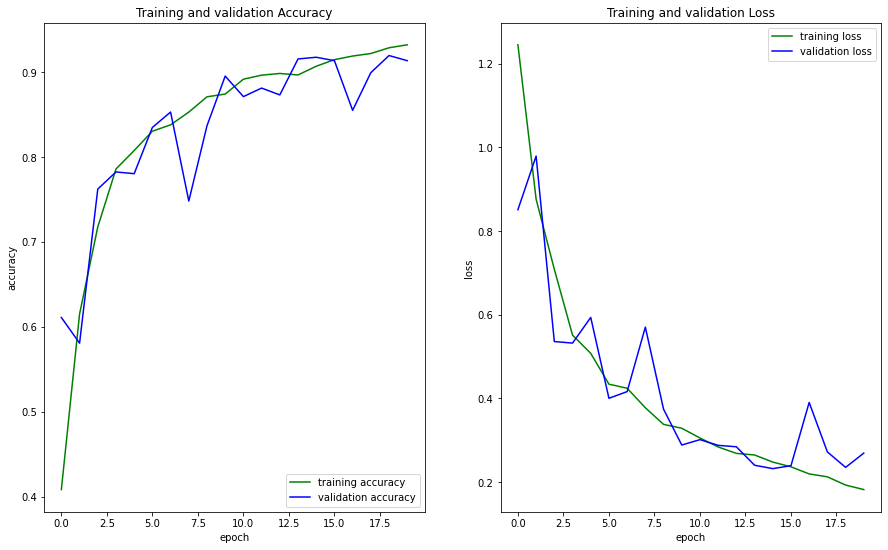

In [26]:
plt.figure(figsize=(15,9))
#accuracy graph
plt.subplot(1,2,1)
plt.plot(acc,'g',label='training accuracy')
plt.plot(val_acc,'b',label='validation accuracy')
plt.legend(loc='lower right')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Training and validation Accuracy')

#loss graph
plt.subplot(1,2,2)
plt.plot(loss,'g',label='training loss')
plt.plot(val_loss,'b',label='validation loss')
plt.legend(loc='upper right')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Training and validation Loss')
plt.show()

In [31]:
from sklearn.metrics import confusion_matrix, classification_report,plot_confusion_matrix

import sklearn.metrics as metrics

import seaborn as sns

y_pred = model.predict(test_generator)
plt.figure(figsize=(8,9))
y_prediction_labels=[np.argmax(label) for label in y_pred]
cm=confusion_matrix(test_generator.classes,y_prediction_labels)
sns.heatmap(cm,annot=True,cmap="Blues",cbar=False,fmt='d',xticklabels=class_names,yticklabels=class_names,)

ImportError: ignored

In [32]:
Y_pred = model.predict(test_generator, test_generator.samples // BATCH_SIZE)
y_pred = np.argmax(Y_pred, axis=1)
print('Classification Report')

print(classification_report(test_generator.classes, y_pred))

63/63 [==============================] - 36s 560ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.26      0.29      0.28       100
           1       0.21      0.20      0.21       100
           2       0.20      0.19      0.19       100
           3       0.20      0.23      0.21       100
           4       0.25      0.22      0.24       100

    accuracy                           0.23       500
   macro avg       0.23      0.23      0.23       500
weighted avg       0.23      0.23      0.23       500



In [33]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i])
    img_array=tf.expand_dims(img_array,0)#create a batch
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 24ms/step


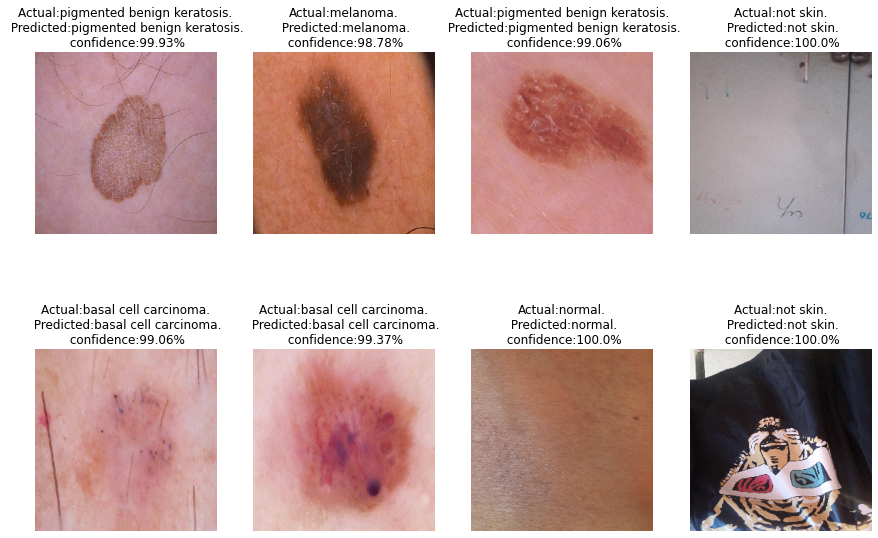

In [34]:
plt.figure(figsize=(15,10))
for images,labels in test_generator:
    for i in range (8):
        plt.subplot(2,4,i+1)
        plt.imshow(images[i])
        
        predicted_class,confidence=predict(model,images[i])
        actual_class=class_names[int(labels[i])]
        
        plt.title(f"Actual:{actual_class}.\n Predicted:{predicted_class}.\n confidence:{confidence}%")
        plt.axis('off')
    plt.show()
    break

In [36]:
model.save('myModel5.h5')

In [37]:
my_model=load_model('myModel5.h5')

In [38]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 128)      0

In [39]:
train_loss,train_acc=my_model.evaluate(train_generator,steps=steps_per_epoch,verbose=0)
val_loss,val_acc=my_model.evaluate(val_generator,steps=validation_step ,verbose=0)
print('Train: %0.3f,Test: %0.3f' %(train_acc,val_acc))
print('Train_Loss: %0.3f,Test_Loss: %0.3f' %(train_loss,val_loss))

Train: 0.941,Test: 0.911
Train_Loss: 0.173,Test_Loss: 0.271


In [40]:
my_model.evaluate(test_generator)

63/63 [==============================] - 42s 662ms/step - loss: 0.2677 - accuracy: 0.9200


[0.26766103506088257, 0.9200000166893005]